In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pdPath
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import metrics
import copy
import time
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE

In [2]:
# CED
# train_val, test = nonlinear_benchmarks.CED()
# print(test[0].state_initialization_window_length) # = 4
# (train_val_u_1, train_val_y_1), (train_val_u_2, train_val_y_2) = train_val
# (test_u_1, test_y_1), (test_u_2, test_y_2) = test

# WienerHammerstein
# train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
# seq_len_n_in_ext = test.state_initialization_window_length
# train_val_u, train_val_y = train_val
# test_u, test_y = test
# ctx_length = 100000
# n_query = test_y.shape[0]

# Silverbox
train, test = nonlinear_benchmarks.Silverbox()
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
(train_val_u, train_val_y) = train
(test_u_1, test_y_1) = test_multisine
(test_u_2, test_y_2) = test_arrow_full
(test_u_3, test_y_3) = test_arrow_no_extrapolation
ctx_length = train_val_u.shape[0]
n_query1 = test_y_1.shape[0]
n_query2 = test_y_2.shape[0]
n_query3 = test_y_3.shape[0]
n = test_multisine.state_initialization_window_length

In [3]:
n_query3

32000

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(452)
np.random.seed(55)
system_seed = 66 # Controls the system generation
data_seed = 0 # Controls the input generation

In [5]:
# Overall settings
out_dir_name = "active_430_400skip_decoder"

# System settings
nu = 1
ny = 1
fixed_system = False # Are we testing on a fixed system?

# Compute settings
no_cuda = False
threads = 5
cuda_device = 'cuda:0'
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = torch.cuda.is_available()
device_name = cuda_device if use_cuda else "cpu"
print(device_name)
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu'
torch.set_float32_matmul_precision("high")


cuda:0


In [6]:

# Create out dir
out_dir = Path(out_dir_name)
exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k.pt", map_location=device)
exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k.pt", map_location=device)
# exp_data = torch.load(out_dir / "resume_top32_over160_fixed_err0.01.pt", map_location=device) # for focusing more on the tails

cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

cfg2 = exp_data2["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg2.seed
except AttributeError:
    cfg2.seed = None

In [7]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
# model = TSTransformer_paper(conf).to(device)/
model.load_state_dict(exp_data["model"]);
# cfg.seed +=1

1


In [8]:
model_args2 = exp_data2["model_args"]
conf2 = Config(**model_args2)
model2 = TSTransformer(conf2).to(device)
# model = TSTransformer_paper(conf).to(device)/
model2.load_state_dict(exp_data2["model"]);
# cfg.seed +=1

1


In [9]:
# model_args3 = exp_data3["model_args"]
# conf3 = Config(**model_args3)
# model3 = TSTransformer(conf3).to(device)
# # model = TSTransformer_paper(conf).to(device)/
# model3.load_state_dict(exp_data3["model"]);

In [9]:
b = 216
b2 = 404
b3 = 319

b_train = 162


train_val_y,train_val_u,test_u_1, test_y_1 = torch.tensor(train_val_y).view(1,ctx_length,1),torch.tensor(train_val_u).view(1,ctx_length,1),torch.tensor(test_u_1).view(1,n_query1,1),torch.tensor(test_y_1).view(1,n_query1,1)
test_u_1 = test_u_1[:,:b*100+30,:].to(device)
test_y_1 = test_y_1[:,:b*100+30,:].to(device)
train_val_u = train_val_u[:,:b_train*400,:].to(device)
train_val_y = train_val_y[:,:b_train*400,:].to(device)

mean_train_u_1, std_train_u_1, mean_train_y_1, std_train_y_1 = train_val_u.mean(),train_val_u.std(),train_val_y.mean(),train_val_y.std()
train_val_y_norm, train_val_u_norm, test_u_1_norm, test_y_1_norm = (train_val_y-mean_train_y_1)/(std_train_y_1+1e-6),(train_val_u-mean_train_u_1)/(std_train_u_1+1e-6),(test_u_1-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_1-mean_train_y_1)/(std_train_y_1+1e-6)
train_val_u_norm = torch.stack([train_val_u_norm[0, i * 400 : (i + 1) * 400, :] for i in range(b_train)])
train_val_y_norm = torch.stack([train_val_y_norm[0, i * 400 : (i + 1) * 400, :] for i in range(b_train)])
test_u_1_norm = torch.stack([test_u_1_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b)])
test_y_1_norm = torch.stack([test_y_1_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b)])


test_u_2, test_y_2 = torch.tensor(test_u_2).view(1,n_query2,1),torch.tensor(test_y_2).view(1,n_query2,1)
test_u_2 = test_u_2[:,:b2*100+30,:].to(device)
test_y_2 = test_y_2[:,:b2*100+30,:].to(device)

test_u_2_norm, test_y_2_norm = (test_u_2-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_2-mean_train_y_1)/(std_train_y_1+1e-6)
test_u_2_norm = torch.stack([test_u_2_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_y_2_norm = torch.stack([test_y_2_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b2)])

test_u_3, test_y_3 = torch.tensor(test_u_3).view(1,n_query3,1),torch.tensor(test_y_3).view(1,n_query3,1)
test_u_3 = test_u_3[:,:b3*100+30,:].to(device)
test_y_3 = test_y_3[:,:b3*100+30,:].to(device)

test_u_3_norm, test_y_3_norm = (test_u_3-mean_train_u_1)/(std_train_u_1+1e-6),(test_y_3-mean_train_y_1)/(std_train_y_1+1e-6)
test_u_3_norm = torch.stack([test_u_3_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_y_3_norm = torch.stack([test_y_3_norm[0, i * 100 : ((i + 1) * 100)+30, :] for i in range(b3)])


train_val_y_1_norm = train_val_y_norm.unsqueeze(0).repeat(b, 1, 1, 1)
train_val_u_1_norm = train_val_u_norm.unsqueeze(0).repeat(b, 1, 1, 1)

train_val_y_2_norm = train_val_y_norm.unsqueeze(0).repeat(b2, 1, 1, 1)
train_val_u_2_norm = train_val_u_norm.unsqueeze(0).repeat(b2, 1, 1, 1)

train_val_y_3_norm = train_val_y_norm.unsqueeze(0).repeat(b3, 1, 1, 1)
train_val_u_3_norm = train_val_u_norm.unsqueeze(0).repeat(b3, 1, 1, 1)

test_u_1_norm = test_u_1_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_1_norm = test_y_1_norm.unsqueeze(1).repeat(1, b_train, 1, 1)

test_u_2_norm = test_u_2_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_2_norm = test_y_2_norm.unsqueeze(1).repeat(1, b_train, 1, 1)

test_u_3_norm = test_u_3_norm.unsqueeze(1).repeat(1, b_train, 1, 1)
test_y_3_norm = test_y_3_norm.unsqueeze(1).repeat(1, b_train, 1, 1)


test_y_1_norm_2 = copy.deepcopy(test_y_1_norm)
test_y_2_norm_2 = copy.deepcopy(test_y_2_norm)
test_y_3_norm_2 = copy.deepcopy(test_y_3_norm)
# test_y_1_norm_3 = copy.deepcopy(test_y_1_norm)



In [10]:
start_time = time.time()
with torch.no_grad():
    estimate_mean_y_1_norm = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_1_norm = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_mean_y_1_norm_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_1_norm_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_mean_y_2_norm = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_2_norm = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_mean_y_2_norm_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_2_norm_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_mean_y_3_norm = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_3_norm = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_mean_y_3_norm_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    estimate_var_y_3_norm_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    # estimate_mean_y_1_norm_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    # estimate_var_y_1_norm_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])
    rmse1 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    rmse1_2 = torch.zeros([b,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    rmse2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    rmse2_2 = torch.zeros([b2,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    rmse3 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    rmse3_2 = torch.zeros([b3,b_train,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])]).to(device)
    # rmse1_3 = torch.zeros([b,b2,cfg.seq_len_new,len(train_val_y_1_norm[0,0,0,:])])

    
    for i in range(b):
        estimate_mean_y_1_norm[i,:,:,:],estimate_var_y_1_norm[i,:,:,:], _, rmse1[i,:,:,:],_ = model(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_1_norm_2[i,:,:,:],estimate_var_y_1_norm_2[i,:,:,:], _, rmse1_2[i,:,:,:],_ = model2(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b-1:
            test_y_1_norm[i+1,:,:30,:] = estimate_mean_y_1_norm[i,:,-30:,:]
            test_y_1_norm_2[i+1,:,:30,:] = estimate_mean_y_1_norm_2[i,:,-30:,:]
            # test_y_1_norm_3[i+1,:,:30,:] = estimate_mean_y_1_norm_3[i,:,-30:,:]
    for i in range(b2):
        estimate_mean_y_2_norm[i,:,:,:],estimate_var_y_2_norm[i,:,:,:], _, rmse2[i,:,:,:],_ = model(train_val_y_2_norm[i,:,:,:].float(), train_val_u_2_norm[i,:,:,:].float(), test_u_2_norm[i,:,:,:].float(),test_y_2_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_2_norm_2[i,:,:,:],estimate_var_y_2_norm_2[i,:,:,:], _, rmse2_2[i,:,:,:],_ = model2(train_val_y_2_norm[i,:,:,:].float(), train_val_u_2_norm[i,:,:,:].float(), test_u_2_norm[i,:,:,:].float(),test_y_2_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b2-1:
            test_y_2_norm[i+1,:,:30,:] = estimate_mean_y_2_norm[i,:,-30:,:]
            test_y_2_norm_2[i+1,:,:30,:] = estimate_mean_y_2_norm_2[i,:,-30:,:]
    for i in range(b3):
        estimate_mean_y_3_norm[i,:,:,:],estimate_var_y_3_norm[i,:,:,:], _, rmse3[i,:,:,:],_ = model(train_val_y_3_norm[i,:,:,:].float(), train_val_u_3_norm[i,:,:,:].float(), test_u_3_norm[i,:,:,:].float(),test_y_3_norm[i,:,:,:].float(),cfg.seq_len_n_in)
        estimate_mean_y_3_norm_2[i,:,:,:],estimate_var_y_3_norm_2[i,:,:,:], _, rmse3_2[i,:,:,:],_ = model2(train_val_y_3_norm[i,:,:,:].float(), train_val_u_3_norm[i,:,:,:].float(), test_u_3_norm[i,:,:,:].float(),test_y_3_norm_2[i,:,:,:].float(),cfg.seq_len_n_in)
        # estimate_mean_y_1_norm_3[i,:,:,:],estimate_var_y_1_norm_3[i,:,:,:], _, rmse1_3[i,:,:,:],_ = model3(train_val_y_1_norm[i,:,:,:].float(), train_val_u_1_norm[i,:,:,:].float(), test_u_1_norm[i,:,:,:].float(),test_y_1_norm_3[i,:,:,:].float(),cfg.seq_len_n_in)
        if i != b3-1:
            test_y_3_norm[i+1,:,:30,:] = estimate_mean_y_3_norm[i,:,-30:,:]
            test_y_3_norm_2[i+1,:,:30,:] = estimate_mean_y_3_norm_2[i,:,-30:,:]

print(time.time()-start_time)

estimate_mean_y_1 = estimate_mean_y_1_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_1 = estimate_var_y_1_norm*(std_train_y_1+1e-6)

estimate_mean_y_1_2 = estimate_mean_y_1_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_1_2 = estimate_var_y_1_norm_2*(std_train_y_1+1e-6)

estimate_mean_y_2 = estimate_mean_y_2_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_2 = estimate_var_y_2_norm*(std_train_y_1+1e-6)

estimate_mean_y_2_2 = estimate_mean_y_2_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_2_2 = estimate_var_y_2_norm_2*(std_train_y_1+1e-6)

estimate_mean_y_3 = estimate_mean_y_3_norm*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_3 = estimate_var_y_3_norm*(std_train_y_1+1e-6)

estimate_mean_y_3_2 = estimate_mean_y_3_norm_2*(std_train_y_1+1e-6)+mean_train_y_1
estimate_var_y_3_2 = estimate_var_y_3_norm_2*(std_train_y_1+1e-6)

# estimate_mean_y_1_3 = estimate_mean_y_1_norm_3*(std_train_y_1+1e-6)+mean_train_y_1
# estimate_var_y_1_3 = estimate_var_y_1_norm_3*(std_train_y_1+1e-6)

201.3359408378601


In [11]:
estimate_mean_y_1_norm = estimate_mean_y_1_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_1 = estimate_mean_y_1[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_1_norm = estimate_var_y_1_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_1 = estimate_var_y_1[:,:,:, :].to("cpu").detach().numpy()
test_u_1 = torch.stack([test_u_1[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b)])
test_y_1 = torch.stack([test_y_1[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b)])
test_u_1 = test_u_1.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_1 = test_y_1.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_1_norm = test_u_1_norm.to("cpu").detach().numpy()
test_y_1_norm = test_y_1_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_1 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_1 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_1 - estimate_var_y_1 * 3


estimate_mean_y_2_norm = estimate_mean_y_2_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_2 = estimate_mean_y_2[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_2_norm = estimate_var_y_2_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_2 = estimate_var_y_2[:,:,:, :].to("cpu").detach().numpy()
test_u_2 = torch.stack([test_u_2[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_y_2 = torch.stack([test_y_2[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b2)])
test_u_2 = test_u_2.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_2 = test_y_2.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_2_norm = test_u_2_norm.to("cpu").detach().numpy()
test_y_2_norm = test_y_2_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_2 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_2 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_2 - estimate_var_y_1 * 3

estimate_mean_y_3_norm = estimate_mean_y_3_norm[:,:, :, :].to("cpu").detach().numpy()
estimate_mean_y_3 = estimate_mean_y_3[:,:, :, :].to("cpu").detach().numpy()
estimate_var_y_3_norm = estimate_var_y_3_norm[:,:,:, :].to("cpu").detach().numpy()
estimate_var_y_3 = estimate_var_y_3[:,:,:, :].to("cpu").detach().numpy()
test_u_3 = torch.stack([test_u_3[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_y_3 = torch.stack([test_y_3[0, i * 100 +30 : ((i + 1) * 100)+30, :] for i in range(b3)])
test_u_3 = test_u_3.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_y_3 = test_y_3.unsqueeze(1).repeat(1, b_train, 1, 1).to("cpu").detach().numpy()
test_u_3_norm = test_u_3_norm.to("cpu").detach().numpy()
test_y_3_norm = test_y_3_norm.to("cpu").detach().numpy()
# first_sim_err = test_y_1 - estimate_mean_y_1
# first_y_plus = estimate_mean_y_1 + estimate_var_y_1 * 3
# first_y_minus = estimate_mean_y_1 - estimate_var_y_1 * 3


In [12]:
estimate_mean_y_1_norm_2 = estimate_mean_y_1_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_1_2 = estimate_mean_y_1_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_1_norm_2 = estimate_var_y_1_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_1_2 = estimate_var_y_1_2[:,:, :].to("cpu").detach().numpy()

estimate_mean_y_2_norm_2 = estimate_mean_y_2_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_2_2 = estimate_mean_y_2_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_2_norm_2 = estimate_var_y_2_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_2_2 = estimate_var_y_2_2[:,:, :].to("cpu").detach().numpy()

estimate_mean_y_3_norm_2 = estimate_mean_y_3_norm_2[:, :, :].to("cpu").detach().numpy()
estimate_mean_y_3_2 = estimate_mean_y_3_2[:, :, :].to("cpu").detach().numpy()
estimate_var_y_3_norm_2 = estimate_var_y_3_norm_2[:,:, :].to("cpu").detach().numpy()
estimate_var_y_3_2 = estimate_var_y_3_2[:,:, :].to("cpu").detach().numpy()

# estimate_mean_y_1_norm_3 = estimate_mean_y_1_norm_3[:, :, :].to("cpu").detach().numpy()
# estimate_mean_y_1_3 = estimate_mean_y_1_3[:, :, :].to("cpu").detach().numpy()
# estimate_var_y_1_norm_3 = estimate_var_y_1_norm_3[:,:, :].to("cpu").detach().numpy()
# estimate_var_y_1_3 = estimate_var_y_1_3[:,:, :].to("cpu").detach().numpy()
# test_y_1 = test_y[:,30:130,:].to("cpu").detach().numpy()

# first_sim_err_3 = test_y_1 - estimate_mean_y_1_3
# first_y_plus_3 = estimate_mean_y_1_3 + estimate_var_y_1_3 * 3
# first_y_minus_3 = estimate_mean_y_1_3 - estimate_var_y_1_3 * 3

In [13]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse1 = metrics.rmse_test(test_y_1, estimate_mean_y_1, time_axis=2)
rmse1_2 = metrics.rmse_test(test_y_1, estimate_mean_y_1_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse for mulisine component of Silverbox with robust and classic approach{rmse1.mean(),rmse1_2.mean()}, respectively")

rmse for mulisine component of Silverbox with robust and classic approach(0.008369204652733773, 0.009274076304114906), respectively


In [14]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse2 = metrics.rmse_test(test_y_2, estimate_mean_y_2, time_axis=2)
rmse2_2 = metrics.rmse_test(test_y_2, estimate_mean_y_2_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)


print(f"rmse for full arrow component of Silverbox with robust and classic approach{rmse2.mean(),rmse2_2.mean()}, respectively")

rmse for full arrow component of Silverbox with robust and classic approach(0.010795302921089392, 0.010876297815186236), respectively


In [15]:
#Silverbox2_fixingcontext_overquery_arrowfull
skip = 0
rmse3 = metrics.rmse_test(test_y_3, estimate_mean_y_3, time_axis=2)
rmse3_2 = metrics.rmse_test(test_y_3, estimate_mean_y_3_2, time_axis=2)
# rmse3 = metrics.rmse_test(test_y_1, estimate_mean_y_1_3, time_axis=2)

print(f"rmse for arrow no extrapolation component of Silverbox with robust and classic approach{rmse3.mean(),rmse3_2.mean()}, respectively")

rmse for arrow no extrapolation component of Silverbox with robust and classic approach(0.006307538756063822, 0.006846541413759271), respectively


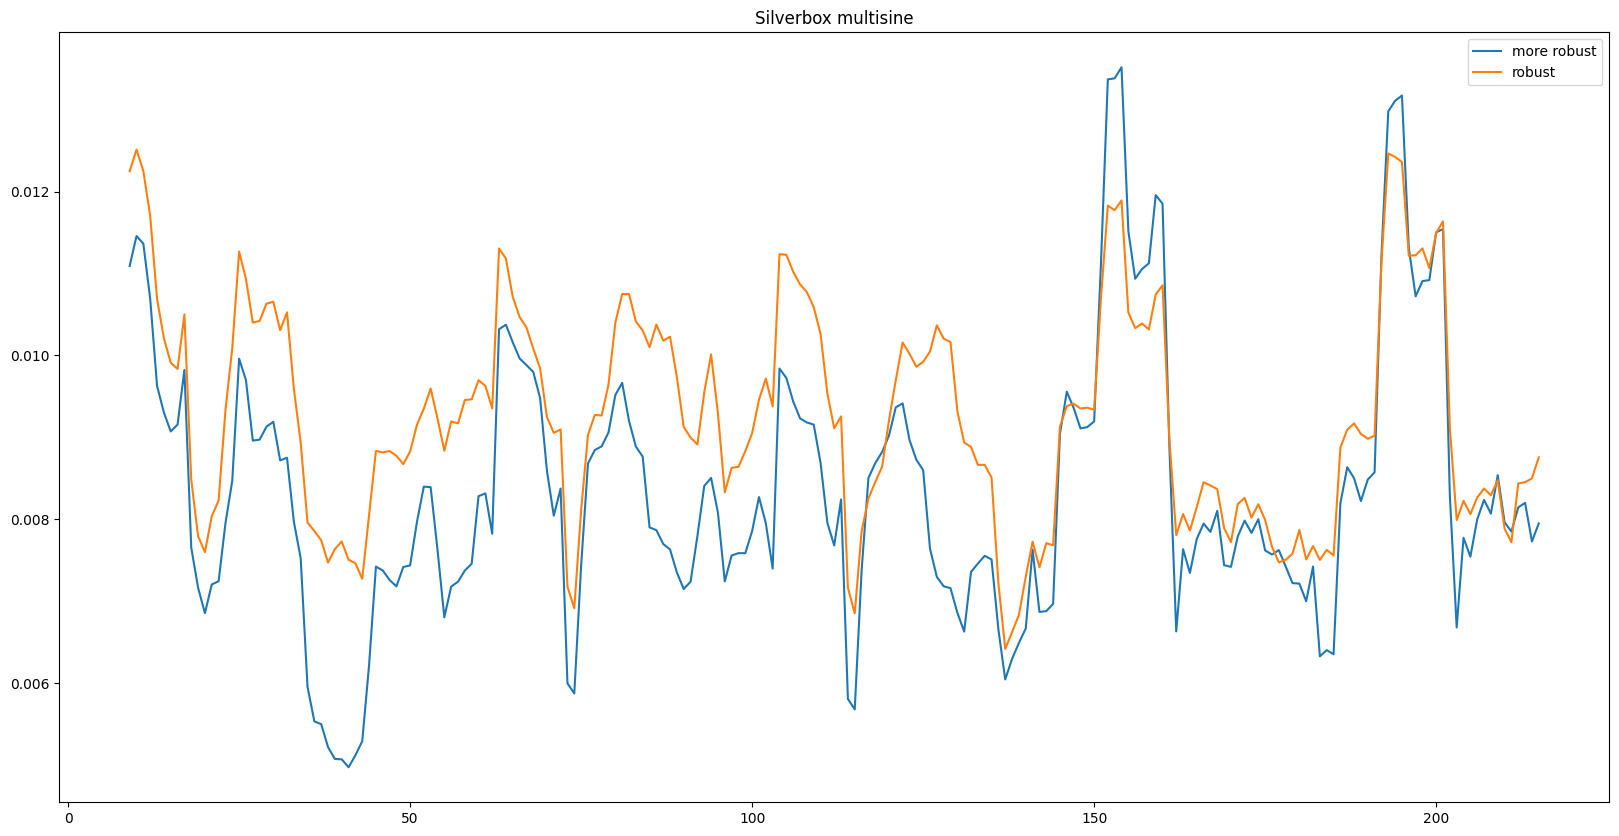

In [18]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(b),pd.Series(rmse1.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'more robust')
plt.plot(np.arange(b),pd.Series(rmse1_2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
# plt.plot(np.arange(404),pd.Series(rmse3.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')
plt.title("Silverbox multisine")
plt.legend()

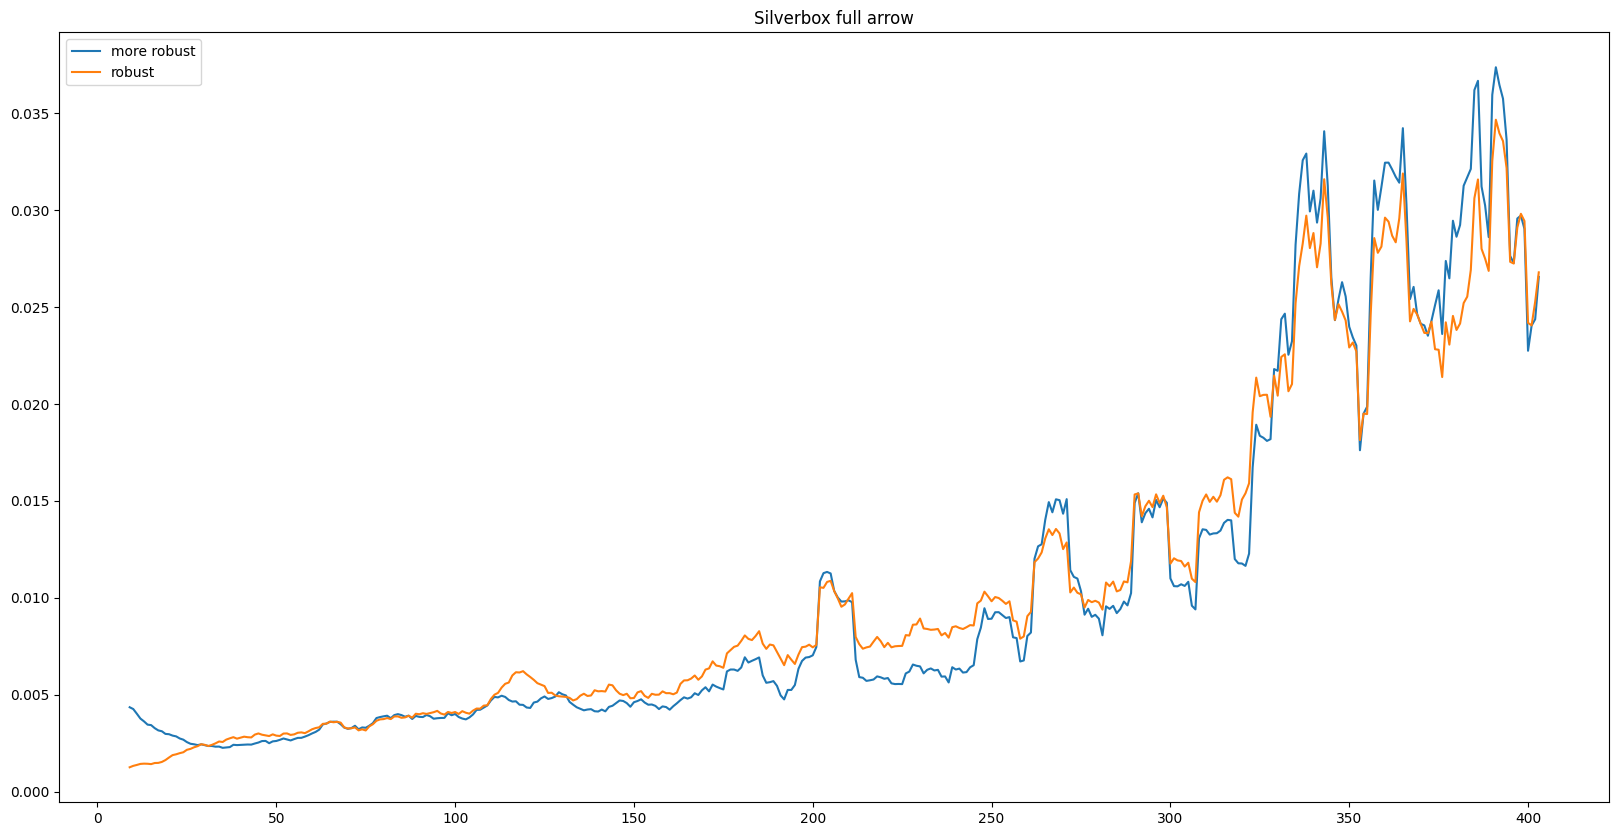

In [19]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(b2),pd.Series(rmse2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'more robust')
plt.plot(np.arange(b2),pd.Series(rmse2_2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
# plt.plot(np.arange(404),pd.Series(rmse3.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')
plt.title("Silverbox full arrow")
plt.legend()

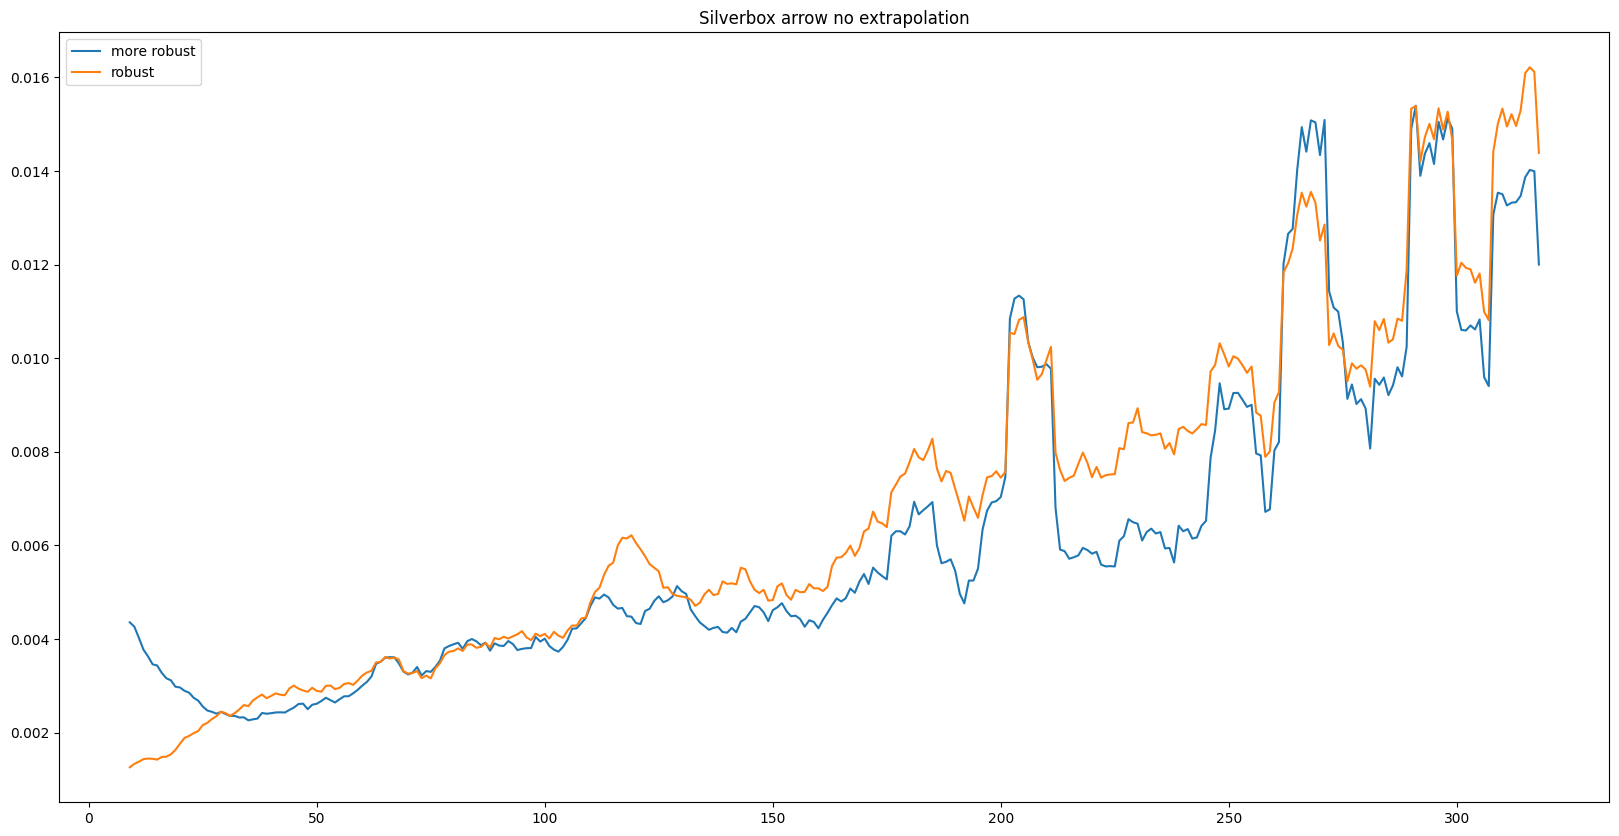

In [20]:
import pandas as pd
plt.figure(figsize=(20,10))
plt.plot(np.arange(b3),pd.Series(rmse3.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'more robust')
plt.plot(np.arange(b3),pd.Series(rmse3_2.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'robust')
# plt.plot(np.arange(404),pd.Series(rmse3.mean(axis = 1).squeeze(-1)).rolling(10).mean(), label = 'classic')
plt.title("Silverbox arrow no extrapolation")
plt.legend()
